### Imports

In [1]:
## Data Management ##
import numpy as np
import os
## Graph Management ##
import networkx as nx
from networkx.algorithms.community import louvain_communities
## Data Visualization ##
import matplotlib.pyplot as plt
## Subgraph Generation and Timer ##
import random
import time
## Skip warnings ##
import warnings
warnings.filterwarnings('ignore')

###
<p style="background-color:#178268; font-family: arial black; color:#FFF9ED; font-size: 300%; text-align: center;">Task 9 - Time Measurements</p>

- First we read the graph from the previous notebook, and the we applied the Louvian Algorithm

In [2]:
# Original Graph
dir = "generated_graphs"
os.makedirs(dir, exist_ok=True)
G = nx.read_graphml(os.path.join(dir, f"original_graph.graphml"))

# Task 7 Community Clsutering
lc = louvain_communities(G, seed=1)

#### p & q Parameters

Now we estimate the p and q parameters for the rawComm future measure
- p, probability of an edge between two nodes in the same community (actual intra-edges / possible intra-edges)
- q, probability of an edge between two nodes in different communities (actual inter-edges / possible inter-edges)

In [3]:
def estimate_pq(graph, communities):
    intra_edges = 0
    intra_possible = 0
    inter_edges = 0
    inter_possible = 0
    node_community = {}

    # Mapping every node to its community 
    for i, community in enumerate(communities):
        for node in community:
            node_community[node] = i

    nodes = list(graph.nodes())

    # Iteration all unique ordered pairs of nodes
    for i, u in enumerate(nodes):
        for v in nodes[i+1:]:
            # Check if both nodes are in the same community
            same_comm = (node_community[u] == node_community[v])
            # Check if the edge exists
            edge_exists = graph.has_edge(u, v)

            # p filter
            if same_comm:
                intra_possible += 1
                if edge_exists:
                    intra_edges += 1
            
            # q filter
            else:
                inter_possible += 1
                if edge_exists:
                    inter_edges += 1

    p = intra_edges / intra_possible if intra_possible else 0
    q = inter_edges / inter_possible if inter_possible else 0
    return p, q

p,q = estimate_pq(G, lc)
p,q

(0.06252590258282961, 0.00016910431963090293)

#### rawComm function

In [ ]:
def raw_comm(G, p, q):
    # Dictionaty to gather all the nodes score
    raw_comm_scores = {}

    # Loop all nodes
    for u in G.nodes():
        # Nodes Neighbours
        N_u = set(G.neighbors(u))
        score = 0

        for v in N_u:
            #Neighbours of v
            N_v = set(G.neighbors(v))
            # filter of same neighbours
            shared_neighbors = N_u & N_v
            # u Neighbors that are not neighbours of v and are not v
            non_shared_neighbors = N_u - (N_v | {v})

            tau_uv = 1 / (1 + p * len(shared_neighbors) + (1 - q) * len(non_shared_neighbors))
            score += tau_uv
        # To aux dictonary
        raw_comm_scores[u] = score
    return raw_comm_scores

#### Induced subgraphs

- Functions to create a induced subgraphs at random with uniform probabilities & with probabilities proportional to degree of the nodes

In [5]:
def sample_uniform(G, size):
    return random.sample(list(G.nodes()), size)

def sample_by_degree(G, size):
    nodes, degrees = zip(*G.degree())
    total = sum(degrees)
    probs = [deg / total for deg in degrees]
    return random.choices(list(nodes), weights=probs, k=size)

#### Time execution of rawComm

In [6]:
def time_raw_comm_on_subgraph(G, nodes, p, q):
    subgraph = G.subgraph(nodes)
    start = time.perf_counter()
    raw_comm(subgraph, p, q)
    return time.perf_counter() - start

#### Experiment Execution on Subgraphs

In [7]:
sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] # Subgraph orders
# Aux Arrays
uniform_times = []
degree_times = []
N = 100 # Reasonable number of repetitions
random.seed(1)

for fraction in sizes:
    n = int(len(G.nodes()) * fraction)
    u_times, d_times = [], []
    for r in range(N):
        u_nodes = sample_uniform(G, n)
        d_nodes = sample_by_degree(G, n)
        u_times.append(time_raw_comm_on_subgraph(G, u_nodes, p, q))
        d_times.append(time_raw_comm_on_subgraph(G, d_nodes, p, q))
    # Store runtime
    uniform_times.append(np.mean(u_times))
    degree_times.append(np.mean(d_times))

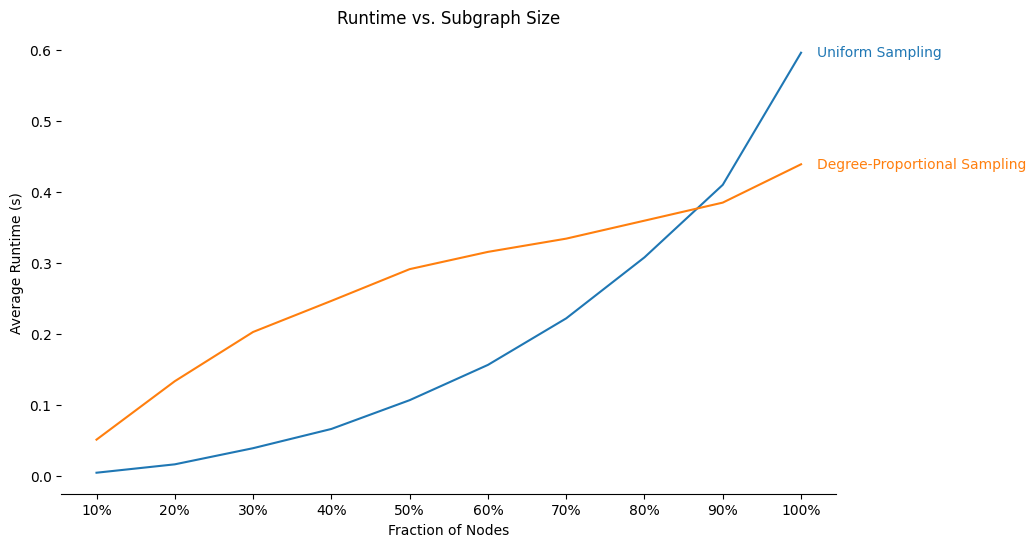

In [8]:
plt.figure(figsize=(10, 6))
# Lines
plt.plot(sizes, uniform_times, label="Uniform Sampling")
plt.plot(sizes, degree_times, label="Degree-Proportional Sampling")
# Title and axis
plt.xlabel("Fraction of Nodes")
plt.ylabel("Average Runtime (s)")
plt.xticks(sizes, [f"{int(s*100)}%" for s in sizes])
plt.title("Runtime vs. Subgraph Size")
# Remove frame
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
# Add labels to the right of each line
plt.text(sizes[-1] + 0.02, uniform_times[-1], "Uniform Sampling", va='center', ha='left', fontsize=10, color=plt.gca().lines[0].get_color())
plt.text(sizes[-1] + 0.02, degree_times[-1], "Degree-Proportional Sampling", va='center', ha='left', fontsize=10, color=plt.gca().lines[1].get_color())
plt.show()

- As we easily expected beforehand, the runtime is being incresing with the subgraph size for both sets. The explanation is easy in this point, more nodes, more computations. Furthermore, as we can even doing iterations and getting the mean time, at small sizes the structure can vary a lot between samples.

- The Degree-proportional is slower in small/medium subgraph sizes. This happens because if the nodes with more degrees have more chances to be in the graph, the more complex neighborhood comparisons to compute.

- On the other hand, the uniform sampling becomes slower only at the full size. This suggest us that this distribution is sparser at small scales, provoking faster rawComm computation